In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline

In [1]:
# import from pythin packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf as xe
import cmocean
from datetime import datetime, date, timedelta

# import from pre-built data classes
from data_handler import *
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from region import Region
from utils import Utils as utls

pfns = pfns()

In [3]:
# load dynamic ocean topography data from class
dot = DOT().ds.dot

# set up stweric height
sha = StericHeight(ssh_ref='DOT',
                   ssh=dot,
                   lwe=GRACE(from_file=False).ds.lwe_thickness,
                   msl=ERA5().ds.msl
                  ).get_sha(startend=[dot.time[0],dot.time[-1]])#[pd.Timestamp(2002,7,1),pd.Timestamp(2017,6,1)])

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xe.Regridder(sice,sha,'bilinear')
sice = regridder(sice)
siz = sice.where(sice > 0.15)

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [5]:
# define seaons
seasons={
    'JFM':[1,2,3],
    'AMJ':[4,5,6],
    'JAS':[7,8,9],
    'OND':[10,11,12]
    }

def get_season(da, season, mean=True): 
    rtn = da.groupby('time.month').mean('time',skipna=True).sel(month=seasons[season])
    return rtn.mean('month') if mean else rtn

In [6]:
dsice = sice.differentiate('time',datetime_unit='D')
dsica = dsice.groupby('time.month') - dsice.groupby('time.month').mean()
sicea = sice - sice.mean('time')

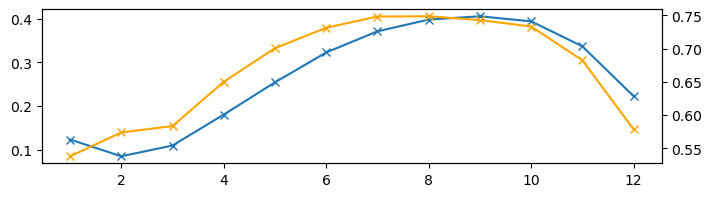

In [7]:
sic_cmt = sice.groupby('time.month').mean()
siz_cmt = siz.groupby('time.month').mean()
fig,ax = plt.subplots(figsize=(8,2))
ax.plot(sic_cmt.month,sic_cmt.mean(['longitude','latitude']),marker='x')
ax.twinx().plot(siz_cmt.month,siz_cmt.mean(['longitude','latitude']),marker='x',c='orange')

In [8]:
in_siz = sic_cmt.sel(month=8) > 0.15
in_piz = sice.quantile(0.1,dim='time')>0.15
in_miz = in_siz & ~in_piz

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [9]:
sic_siz = sic_cmt.sel(month=8).where(~in_siz)

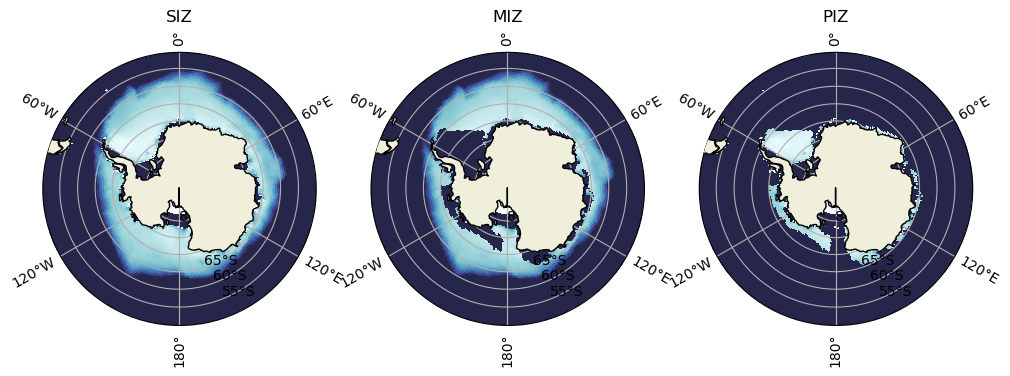

In [10]:
fig,axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': ccrs.SouthPolarStereo()})

pfns.sp(axs[0],sic_cmt.sel(month=8).where(in_siz,other=0.15),title='SIZ',vmin=0,vmax=1,cmap=cmocean.cm.ice)
pfns.sp(axs[1],sic_cmt.sel(month=8).where(in_miz,other=0.15),title='MIZ',vmin=0,vmax=1,cmap=cmocean.cm.ice)
pfns.sp(axs[2],sic_cmt.sel(month=8).where(in_piz,other=0.15),title='PIZ',vmin=0,vmax=1,cmap=cmocean.cm.ice)#bar='Sea Ice Concentration',cbar_orientation='vertical')


In [11]:
sha_cmt = sha.sha.groupby('time.month').mean()

In [12]:
sha_seasonal_removed = sha.sha.groupby('time.month') - sha_cmt

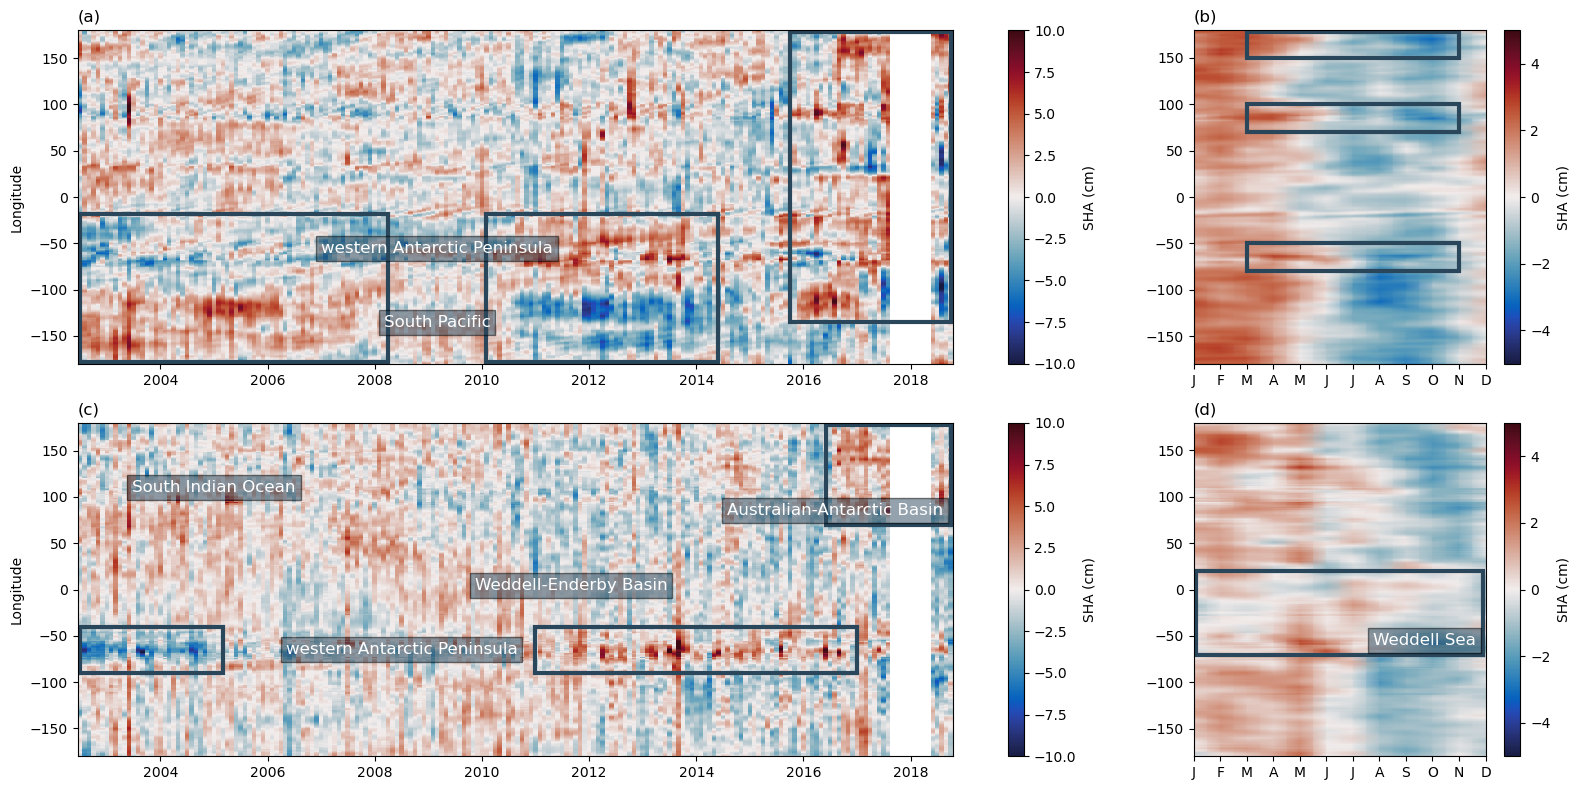

In [53]:
fig,axs = plt.subplots(2,2,figsize=(16,8),gridspec_kw={'width_ratios': [3,1]})

def plot_iz(iz,row,t1,t2):
    # plot time series against longitude
    im1 = axs[row][0].pcolormesh(sha.time,sha.longitude,sha_seasonal_removed.where(iz).mean('latitude').T,cmap=cmocean.cm.balance)#,shading='gouraud')
    im2 = axs[row][1].pcolormesh(sha_cmt.month,sha_cmt.longitude,sha_cmt.where(iz).mean('latitude').T,cmap=cmocean.cm.balance,shading='gouraud')
    im1.set_clim([-10,10])
    im2.set_clim([-5,5])
    cbar1=fig.colorbar(im1,ax=axs[row][0])
    cbar2=fig.colorbar(im2,ax=axs[row][1])
    cbar1.ax.set_ylabel('SHA (cm)')
    cbar2.ax.set_ylabel('SHA (cm)')
    axs[row][0].set_title(t1,loc='left')
    axs[row][1].set_title(t2,loc='left')
    axs[row][0].set_ylabel('Longitude')

    # set up months on x axis of climatology
    axs[row][1].set_xticks(np.arange(1,13))
    axs[row][1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[row][1].set_xlim([1,12])

plot_iz(in_miz,1,'(c)','(d)')#'Marginal Ice Zone')
#plot_iz(in_piz,2,'Permanent Ice Zone')
plot_iz(~in_siz,0, '(a)','(b)')#'Ice-Free Ocean')

fig.tight_layout()

def add_box(ax, t1, t2, l1, l2): 
    width = t2-t1
    height = l2-l1
    box =  patches.Rectangle((t1,l1), width, height, linewidth=3, edgecolor='#29465b', facecolor='none')
    axs.flat[ax].add_patch(box)

def add_text(ax,x,y,txt):
    axs.flat[ax].text(x,y,txt,size=12,c='w',ha='center',bbox=dict(boxstyle="square",facecolor='#29465b',alpha=0.5))

# ice-free ocean timeseries
add_box(0, datetime(2002,7,1), datetime(2008,4,1), -18, -178)
add_box(0, datetime(2010,2,1), datetime(2014,6,1), -18, -178)
add_box(0, datetime(2015,10,1), datetime(2018,10,1), -135, 178)
add_text(0, datetime(2009,3,1), -60, 'western Antarctic Peninsula')
add_text(0, datetime(2009,3,1), -140, 'South Pacific')

# ice-free ocean climatology
add_box(1,3,11,150,178)
add_box(1,3,11,70,100)
add_box(1,3,11,-80,-50)

# siz time series
add_box(2, datetime(2002,7,1), datetime(2005,3,1), -90, -40)
add_box(2, datetime(2011,1,1), datetime(2017,1,1), -90, -40)
add_box(2, datetime(2016,6,1), datetime(2018,10,1), 70, 178)
add_text(2, datetime(2005,1,1), 105, 'South Indian Ocean')
add_text(2, datetime(2011,9,1), 0, 'Weddell-Enderby Basin')
add_text(2, datetime(2008,7,1), -70, 'western Antarctic Peninsula')
add_text(2, datetime(2016,8,1), 80, 'Australian-Antarctic Basin')


# siz climatology
add_box(3, 1.1, 11.9, -70, 20)
add_text(3,9.7,-60,'Weddell Sea')

# im1 = axs[0][0].pcolor(sha.time,sha.longitude,sha_seasonal_removed.where(in_miz).mean('latitude').T,cmap=cmocean.cm.balance)
# axs[0][1].contourf(sha_cmt.month,sha_cmt.longitude,sha_cmt.where(in_miz).mean('latitude').T,cmap=cmocean.cm.balance)
# im1.set_clim([-10,10])
# fig.colorbar(im1,ax=axs[0][0])

# im2 = axs[1][0].pcolor(sha.time,sha.longitude,sha_seasonal_removed.where(in_piz).mean('latitude').T,cmap=cmocean.cm.balance)
# axs[1][1].contourf(sha_cmt.month,sha_cmt.longitude,sha_cmt.where(in_piz).mean('latitude').T,cmap=cmocean.cm.balance)
# fig.colorbar(im2,ax=axs[1][0])

# axs[2][0].contourf(sha.time,sha.longitude,sha_seasonal_removed.where(~in_siz).mean('latitude').T,cmap=cmocean.cm.balance)
# axs[2][1].contourf(sha_cmt.month,sha_cmt.longitude,sha_cmt.where(~in_siz).mean('latitude').T,cmap=cmocean.cm.balance)

